In [238]:
import os
import numpy as np 
import pandas as pd
import scipy
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [239]:
os.chdir('/kaggle/input/BloodPressureDataset')

# ECG Features

An ECG (electrocardiogram) signal is composed of several key components inlcuding P wave, PR interval, QRS complex, ST segment and T wave. 
Distinctive spikes within the QRS complex are known as R-peaks and represent ventricular depolarization. 
The RR interval, measured as the time between consecutive R-peaks, is usually used for heart rate calculation. 
Furthermore, the variability in RR intervals, known as heart rate variability (HRV), is associated with adaptability and health of cardiovascular hsystem. 


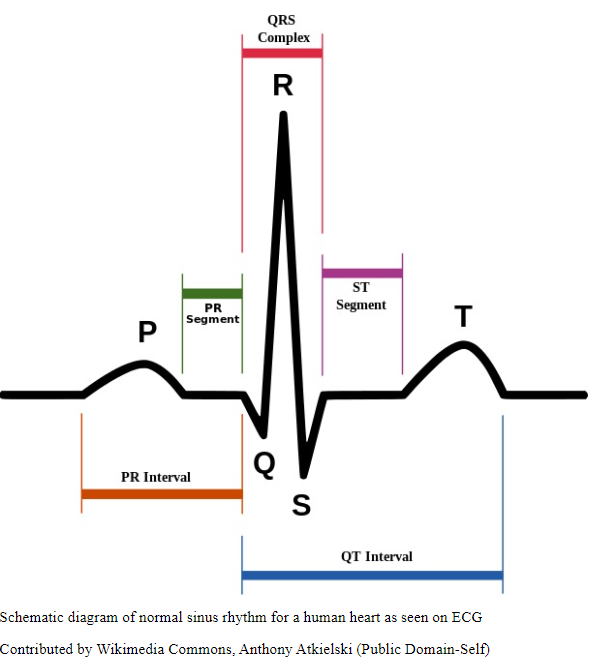

In [240]:
def detect_r_peaks_ecg(signal, sampling_rate, max_hr, threshold_coef):

    e_threshold = np.mean(signal) + threshold_coef * np.std(signal)
    min_distance =  sampling_rate / (max_hr/60)
    peaks, _ = scipy.signal.find_peaks(signal, height=e_threshold, distance=min_distance)

    return np.array(peaks)

In [241]:
def detect_st_segments(ecg_signal, s_wave_threshold=0.5, t_wave_threshold=0.2):
    """Detect ST segments in an ECG signal."""

    # Find the location of the S wave peak
    s_wave_peak_location = r_peak_location + np.argmin(ecg_signal[r_peak_location:])

    # Set the search range for the ST segment
    st_segment_start = s_wave_peak
    st_segment_end = s_wave_peak + 100  # Adjust the range based on your signal characteristics

    # Detect ST segment based on thresholds
    st_segments = np.where((ecg_signal[st_segment_start:st_segment_end] < s_wave_threshold) &
                           (ecg_signal[st_segment_start:st_segment_end] > t_wave_threshold))[0]

    # Adjust indices to the global coordinate system
    st_segments += st_segment_start

    return st_segments

In [242]:
def extract_ecg_features(signal, sampling_rate, min_hr, max_hr, threshold_coef):
    r_peaks = detect_r_peaks_ecg(signal, sampling_rate, max_hr, threshold_coef)

    # Calculate RR intervals
    rr_intervals = np.diff(r_peaks)
    
    #remove outliers 
    filtered_rr_intervals = [rr for rr in rr_intervals if rr >= (60/max_hr)*sampling_rate and rr <=(60/min_hr)*sampling_rate]

    # Calculate heart rate
    if len(filtered_rr_intervals) == 0 or np.median(filtered_rr_intervals) ==0:
        heart_rate, rr_interval_variability = np.nan, np.nan
    else:
        heart_rate = 60.0 / (np.median(filtered_rr_intervals) / sampling_rate)
        rr_interval_variability = np.std(filtered_rr_intervals)/sampling_rate
        
    return heart_rate, rr_interval_variability

# Processing Loop

In [243]:
fs = 125
heart_rates_ecg = []
rr_interval_variability = []

for ii in range(12):
    
    filename = 'part_' + str(ii + 1) + '.mat'
    mat_data = scipy.io.loadmat(filename)['p']
    
    for jj in range(1000):
        ecg_signal = mat_data[0][jj][2]
        heart_rate_ecg, rr_variability = extract_ecg_features(ecg_signal, fs, min_hr=40, max_hr=220, threshold_coef =2)
        
        heart_rates_ecg.append(heart_rate_ecg)
        rr_interval_variability.append(rr_variability)

# Heart Rate

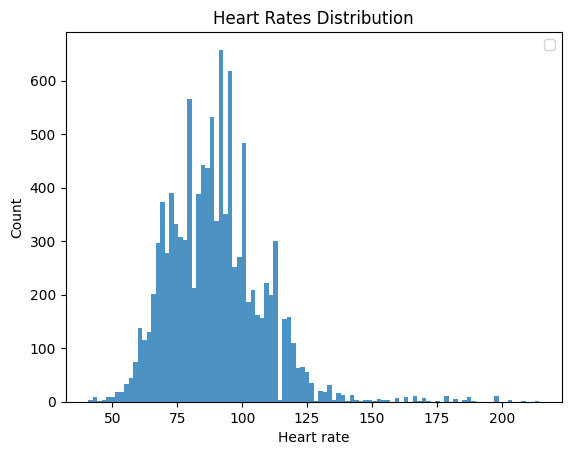

In [245]:
plt.hist(heart_rates_ecg, bins=100, alpha=0.8)
plt.title('Heart Rates Distribution')
plt.xlabel('Heart rate')
plt.ylabel('Count')
plt.legend()

# Heart Rate Variability (HRV) 

Text(0, 0.5, 'Count')

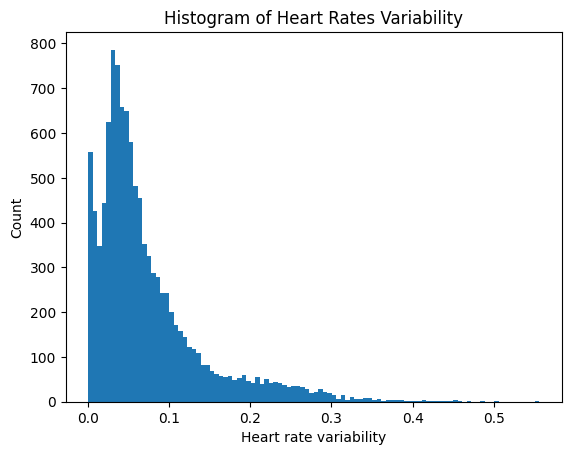

In [246]:
plt.hist(rr_interval_variability, bins= 100)
plt.title('Histogram of Heart Rates Variability')
plt.xlabel('Heart rate variability')
plt.ylabel('Count')
